In [115]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

from tqdm import tqdm

plt.style.use("dark_background")


## The Finite Volume Method in CFD video series

https://youtube.com/playlist?list=PLnJ8lIgfDbkp5DtCPtP2rcqEEUJk-PM8N&si=NvpF64pgI-nEt85i

### Classes

#### Node, Face, Cell classes


In [239]:
class Node:
    def __init__(self, id, coordinates):
        """
        Initialize a node.
        :param id: Global ID for the node.
        :param coordinates: Tuple of coordinates (x, y, z).
        """
        self.id = id
        self.coordinates = coordinates

    #     # TODO: do I even need this?
    #     self.neighbors = []  # List of neighboring node IDs


    # def add_neighbor(self, neighbor_id):
    #     self.neighbors.append(neighbor_id)

    def __repr__(self):
        return f"Node(id={self.id}, coordinates={self.coordinates}" #, neighbors={self.neighbors})"

class Face:
    def __init__(self, id, nodes):
        """
        Initialize a face.
        :param id: Global ID for the face.
        :param nodes: List of node IDs defining the face.
        """
        self.id = id
        self.nodes = nodes  # Nodes that make up the face

    #     # TODO: do I even need this?
    #     self.neighbor_cells = []  # IDs of adjacent cells

    # def add_neighbor_cell(self, cell_id):
    #     self.neighbor_cells.append(cell_id)

    def __repr__(self):
        return f"Face(id={self.id}, nodes={self.nodes}" #, neighbor_cells={self.neighbor_cells})"

class Cell:
    def __init__(self, id, nodes, faces):
        """
        Initialize a cell.
        :param id: Global ID for the cell.
        :param nodes: List of node IDs defining the cell.
        :param faces: List of face IDs defining the cell.
        """
        self.id = id
        self.nodes = nodes  # Nodes that make up the cell
        self.faces = faces  # Faces that bound the cell
        self.neighbor_cells = []  # IDs of adjacent cells

        self.flow_variables = {"T":None, "U":None, "P":None}

    def add_flow_variable(self, variable, value):
        self.flow_variables[variable] = value

    def add_neighbor_cell(self, neighbor_id):
        self.neighbor_cells.append(neighbor_id)

    def __repr__(self):
        return (f"Cell(id={self.id}, nodes={self.nodes}, faces={self.faces}, "
                f"neighbor_cells={self.neighbor_cells}, flow_variables={self.flow_variables})")


# Example usage
node1 = Node(1, (0.0, 0.0, 0.0))
node2 = Node(2, (1.0, 0.0, 0.0))
node3 = Node(3, (1.0, 1.0, 0.0))

face1 = Face(1, [1, 2])
face2 = Face(2, [2, 3])

cell1 = Cell(1, [1, 2, 3], [1, 2])

cell1.add_neighbor_cell(2)  # Cell 2 is a neighbor
# face1.add_neighbor_cell(1)  # Cell 1 is adjacent to face 1
# node1.add_neighbor(2)       # Node 2 is a neighbor of Node 1

#### Mesh class

In [264]:
class Mesh:
    def __init__(self, nodes, faces, cells):
        """
        Initialize an empty Mesh object with lists to store nodes, faces, and cells.
        """
        self.nodes = nodes
        self.faces = faces
        self.cells = cells

    def add_node(self, node):
        """
        Add a Node to the mesh.
        :param node: Node object to add.
        """
        self.nodes.append(node)

    def add_face(self, face):
        """
        Add a Face to the mesh.
        :param face: Face object to add.
        """
        self.faces.append(face)

    def add_cell(self, cell):
        """
        Add a Cell to the mesh.
        :param cell: Cell object to add.
        """
        self.cells.append(cell)

    def get_node(self, node_id):
        """
        Retrieve a Node by its ID.
        :param node_id: ID of the Node to retrieve.
        :return: Node object.
        """
        return next(node for node in self.nodes if node.id == node_id)

    def get_face(self, face_id):
        """
        Retrieve a Face by its ID.
        :param face_id: ID of the Face to retrieve.
        :return: Face object.
        """
        return next(face for face in self.faces if face.id == face_id)

    def get_cell(self, cell_id):
        """
        Retrieve a Cell by its ID.
        :param cell_id: ID of the Cell to retrieve.
        :return: Cell object.
        """
        return next(cell for cell in self.cells if cell.id == cell_id)

    def compute_cell_connectivity(self):
        """
        Compute and assign neighbors for each cell based on shared faces.
        """
        face_to_cells = {}

        # Map faces to the cells they belong to
        for cell in self.cells:
            for face_id in cell.faces:
                if face_id not in face_to_cells:
                    face_to_cells[face_id] = []
                face_to_cells[face_id].append(cell.id)

        # Assign neighbors using shared faces
        for face_id, cell_ids in face_to_cells.items():
            if len(cell_ids) > 1:  # A face shared by more than one cell
                for i, cell_id in enumerate(cell_ids):
                    for neighbor_id in cell_ids[:i] + cell_ids[i + 1:]:
                        self.get_cell(cell_id).add_neighbor_cell(neighbor_id)

    def print_detailed_info(self, config = "NFC"):
        """
        Print detailed information about the mesh, including nodes, faces, and cells.
        """
        if "N" in config:
            print("Nodes:")
            for node in self.nodes:
                print(node)
        if "F" in config:
            print("Faces:")
            for face in self.faces:
                print(face)
        if "C" in config:
            print("Cells:")
            for cell in self.cells:
                print(cell)

    def plot(self):
        """
        Plot the mesh using the plot_system function.
        """
        plot_system(self.nodes, self.faces, self.cells)

    def __repr__(self):
        """
        Return a string representation of the Mesh object.
        """
        return (f"Mesh(\n"
                f"  Nodes: {len(self.nodes)},\n"
                f"  Faces: {len(self.faces)},\n"
                f"  Cells: {len(self.cells)}\n)")


### Utils

#### Creating mesh for choosen system of geometry

In [118]:
def create_2d_rectangular_mesh(system_size, num_cells):
    """
    Create a 2D rectangular mesh with the given system size and number of cells.
    :param system_size: Tuple (width, height) of the system.
    :param num_cells: Tuple (nx, ny) with the number of cells in the x and y directions.
    :return: Lists of nodes, faces, and cells.
    """
    width, height = system_size
    nx, ny = num_cells

    # Generate nodes
    dx = width / nx
    dy = height / ny
    nodes = []
    node_id = 0
    node_map = {}  # Maps (i, j) to node ID
    for j in range(ny + 1):
        for i in range(nx + 1):
            x = i * dx
            y = j * dy
            nodes.append(Node(node_id, (x, y)))
            node_map[(i, j)] = node_id
            node_id += 1

    # Generate faces
    faces = []
    face_id = 0
    face_map = {}  # To ensure unique face IDs
    for j in range(ny):
        for i in range(nx):
            # Vertical face (left)
            left_face_nodes = [node_map[(i, j)], node_map[(i, j + 1)]]
            if tuple(left_face_nodes) not in face_map:
                faces.append(Face(face_id, left_face_nodes))
                face_map[tuple(left_face_nodes)] = face_id
                face_id += 1

            # Horizontal face (bottom)
            bottom_face_nodes = [node_map[(i, j)], node_map[(i + 1, j)]]
            if tuple(bottom_face_nodes) not in face_map:
                faces.append(Face(face_id, bottom_face_nodes))
                face_map[tuple(bottom_face_nodes)] = face_id
                face_id += 1

            if i == nx - 1:
                right_face_nodes = [node_map[(i + 1, j)], node_map[(i + 1, j + 1)]]
                faces.append(Face(face_id, right_face_nodes))
                face_map[tuple(sorted(right_face_nodes))] = face_id
                face_id += 1

            if j == ny - 1:
                top_face_nodes = [node_map[(i, j + 1)], node_map[(i + 1, j + 1)]]
                faces.append(Face(face_id, top_face_nodes))
                face_map[tuple(sorted(top_face_nodes))] = face_id
                face_id += 1


    # Generate cells
    cells = []
    cell_id = 0
    for j in range(ny):
        for i in range(nx):
            cell_nodes = [
                node_map[(i, j)],
                node_map[(i + 1, j)],
                node_map[(i + 1, j + 1)],
                node_map[(i, j + 1)],
            ]
            cell_faces = [
                face_map[tuple(sorted([node_map[(i, j)], node_map[(i, j + 1)]]))],  # Left
                face_map[tuple(sorted([node_map[(i, j)], node_map[(i + 1, j)]]))],  # Bottom
                face_map[tuple(sorted([node_map[(i + 1, j)], node_map[(i + 1, j + 1)]]))],  # Right
                face_map[tuple(sorted([node_map[(i, j + 1)], node_map[(i + 1, j + 1)]]))],  # Top
            ]
            cells.append(Cell(cell_id, cell_nodes, cell_faces))
            cell_id += 1

    return nodes, faces, cells


#### Plotting

In [311]:
def plot_system(nodes, faces, cells):
    """
    Plot the system defined by nodes, faces, and cells.
    :param nodes: List of Node objects.
    :param faces: List of Face objects.
    :param cells: List of Cell objects.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    fontsize = 16
    colors = {
        "Node": "blue",
        "Face": "green",
        "Cell": "orange"
    }

    # Plot faces
    for face in faces:
        node_coords = [nodes[node_id].coordinates for node_id in face.nodes]
        x_coords, y_coords = zip(*node_coords)
        ax.plot(x_coords, y_coords, color=colors["Face"], label="Face" if face.id == 0 else None, linewidth=4)
        mid_x, mid_y = sum(x_coords) / 2, sum(y_coords) / 2
        ax.text(mid_x, mid_y, f'{face.id}', color=colors["Face"], fontsize=fontsize)

    # Plot cells
    for cell in cells:
        cell_coords = [nodes[node_id].coordinates for node_id in cell.nodes]
        x_coords, y_coords = zip(*cell_coords + [cell_coords[0]])  # Close the polygon
        ax.plot(x_coords, y_coords, color=colors["Cell"], label="Cell" if cell.id == 0 else None, linewidth = 1)
        center_x = sum(coord[0] for coord in cell_coords) / len(cell_coords)
        center_y = sum(coord[1] for coord in cell_coords) / len(cell_coords)
        ax.text(center_x, center_y, f'{cell.id}', color=colors["Cell"], fontsize=fontsize)

    # Plot nodes
    for node in nodes:
        x, y = node.coordinates
        ax.plot(x, y, 'o', color=colors["Node"], label="Node" if node.id == 0 else None, linewidth = 1)
        ax.text(x, y, f'{node.id}', color=colors["Node"], fontsize=fontsize, ha='left', va='bottom')


    # Configure plot
    ax.set_aspect('equal')
    ax.set_title("System Plot")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend(loc="upper right", fontsize=10)
    # plt.grid(True)
    plt.show()


def plot_scalar_field(mesh, variable_name, num_cells, system_size, plot_mesh = False):
    """
    Plot a scalar field (e.g., 'T', 'P') using a pseudocolor map (pcolormesh).
    :param mesh: Mesh object containing cells.
    :param variable_name: Name of the scalar field to plot ('T', 'P').
    :param num_cells: Tuple indicating the number of cells in (x, y) directions.
    #:param system_size: Tuple indicating the system size (width, height).
    """
    # Extract the flow variable values for each cell
    scalar_field = np.array([
        cell.flow_variables.get(variable_name, None) for cell in mesh.cells
    ])

    if None in scalar_field:
        print(f"Warning: Some cells do not have values for {variable_name}. Setting to NaN.")
        scalar_field = np.array([val if val is not None else np.nan for val in scalar_field])

    # Reshape the scalar field into a 2D grid based on num_cells
    scalar_field_2d = scalar_field.reshape(num_cells)

    cell_size = (system_size[0] / num_cells[0], system_size[1] / num_cells[1])
    # Create a grid for cell centers
    x_centers = np.linspace(0, system_size[0], num_cells[0] + 1)[:-1] + cell_size[0] / 2
    y_centers = np.linspace(0, system_size[1], num_cells[1] + 1)[:-1] + cell_size[1] / 2
    X, Y = np.meshgrid(x_centers, y_centers)

    plt.figure(figsize=(8, 6))

    # Plot the pseudocolor map
    cmap = "coolwarm"  # "viridis", "plasma", "coolwarm"
    plt.pcolormesh(X, Y, scalar_field_2d.T, cmap=cmap, shading='auto')
    plt.colorbar(label=variable_name)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Pseudocolor map of {variable_name}")

    if plot_mesh:
        fontsize = 16
        colors = {
            "Node": "blue",
            "Face": "green",
            "Cell": "orange"
        }
        # Plot faces
        for face in mesh.faces:
            node_coords = [nodes[node_id].coordinates for node_id in face.nodes]
            x_coords, y_coords = zip(*node_coords)
            plt.plot(x_coords, y_coords, color=colors["Face"], label="Face" if face.id == 0 else None, linewidth=4)
            mid_x, mid_y = sum(x_coords) / 2, sum(y_coords) / 2
            plt.text(mid_x, mid_y, f'{face.id}', color=colors["Face"], fontsize=fontsize)
        # Plot cells
        for cell in mesh.cells:
            cell_coords = [nodes[node_id].coordinates for node_id in cell.nodes]
            x_coords, y_coords = zip(*cell_coords + [cell_coords[0]])  # Close the polygon
            plt.plot(x_coords, y_coords, color=colors["Cell"], label="Cell" if cell.id == 0 else None, linewidth = 1)
            center_x = sum(coord[0] for coord in cell_coords) / len(cell_coords)
            center_y = sum(coord[1] for coord in cell_coords) / len(cell_coords)
            plt.text(center_x, center_y, f'{cell.id}', color=colors["Cell"], fontsize=fontsize)
        # Plot nodes
        for node in mesh.nodes:
            x, y = node.coordinates
            plt.plot(x, y, 'o', color=colors["Node"], label="Node" if node.id == 0 else None, linewidth = 1)
            plt.text(x, y, f'{node.id}', color=colors["Node"], fontsize=fontsize, ha='left', va='bottom')


    plt.show()


#### Calculating Volume

In [188]:
def get_cell_centroid(mesh, cell):
    """
    Compute the centroid of a given cell
    :param mesh: Mesh object
    :param cell: Cell object
    :return: Centroid of the cell
    """
    return np.mean([mesh.nodes[node_id].coordinates for node_id in cell.nodes], axis=0)

def get_face_centroid(mesh, face):
    """
    Compute the centroid of a given face
    :param mesh: Mesh object
    :param face: Face object
    :return: Centroid of the face
    """
    return np.mean([mesh.nodes[node_id].coordinates for node_id in face.nodes], axis=0)

def get_face_area(mesh, face):
    """
    Compute the surface area of a given face
    :param mesh: Mesh object
    :param face: Face object
    :return: Surface area of the face
    """
    node_1 = mesh.get_node(face.nodes[0]); node_2 = mesh.get_node(face.nodes[1])
    node_1_coords = np.array(node_1.coordinates); node_2_coords = np.array(node_2.coordinates)
    return np.linalg.norm(node_2_coords - node_1_coords)

def get_face_normal_vector(mesh, face, x_f):
    """
    Compute the normal vector of a given face
    :param mesh: Mesh object
    :param face: Face object
    :param x_f: Vector from the cell centroid to the face midpoint
    :return: Normal vector of the face
    """
    node_1 = mesh.get_node(face.nodes[0]); node_2 = mesh.get_node(face.nodes[1])
    node_1_coords = np.array(node_1.coordinates); node_2_coords = np.array(node_2.coordinates)
    v = node_2_coords - node_1_coords
    n_f = np.array([-v[1], v[0]]) / np.linalg.norm(np.array([-v[1], v[0]]))

    if np.dot(n_f, x_f) < 0: # make sure normal is pointing outwards
        return -n_f
    else:
        return n_f


def compute_cell_volume(mesh, cell):
    """
    Compute the volume of a given cell
    :param mesh: Mesh object
    :param cell: Cell object
    :return: Volume of the cell.
    """
    total_volume = 0.0
    cell_centroid = get_cell_centroid(mesh, cell)

    for face_id in cell.faces:
        face_centroid = get_face_centroid(mesh, mesh.get_face(face_id))
        A_f = get_face_area(mesh, mesh.get_face(face_id))
        x_f = face_centroid - cell_centroid # vector from the cell centroid to the face midpoint
        n_f = get_face_normal_vector(mesh, mesh.get_face(face_id), x_f)

        total_volume += np.abs(1/2 * np.dot(x_f, n_f) * A_f) # 1/3 if 3D
    return total_volume


#### Gradient schemes

In [265]:
def assign_field_to_cells(mesh, field, field_key = "T"):
    """
    Assigns given field to cells based on their IDs.
    :param mesh: Mesh object
    :param field: Field of values, with the same length as the number of cells: scalar->(Nx1), vector->(Nx2)
    :param field_key: Key for the field in the cell object
    """

    if len(field) != len(mesh.cells):
        raise ValueError("Field and mesh must have the same number of cells.")
    if field_key not in ["T", "U", "P"]:
        raise ValueError("Invalid field key. Must be 'T', 'U', or 'P'.")

    for cell in mesh.cells:
        cell.add_flow_variable(field_key, field[cell.id])


def green_gauss_gradient(mesh, cell, field, is_cell_based = True):
    pass


### Steps for FVM

#### Creating a mesh

ic| mesh: Mesh(
            Nodes: 16,
            Faces: 24,
            Cells: 9
          )
ic| 'Nodes:'
ic| node: Node(id=0, coordinates=(0.0, 0.0)
ic| node: Node(id=1, coordinates=(0.3333333333333333, 0.0)
ic| node: Node(id=2, coordinates=(0.6666666666666666, 0.0)
ic| node: Node(id=3, coordinates=(1.0, 0.0)
ic| node: Node(id=4, coordinates=(0.0, 0.3333333333333333)
ic| node: Node(id=5, coordinates=(0.3333333333333333, 0.3333333333333333)
ic| node: Node(id=6, coordinates=(0.6666666666666666, 0.3333333333333333)
ic| node: Node(id=7, coordinates=(1.0, 0.3333333333333333)
ic| node: Node(id=8, coordinates=(0.0, 0.6666666666666666)
ic| node: Node(id=9, coordinates=(0.3333333333333333, 0.6666666666666666)
ic| node: Node(id=10, coordinates=(0.6666666666666666, 0.6666666666666666)
ic| node: Node(id=11, coordinates=(1.0, 0.6666666666666666)
ic| node: Node(id=12, coordinates=(0.0, 1.0)
ic| node: Node(id=13, coordinates=(0.3333333333333333, 1.0)
ic| node: Node(id=14, coordinates=(0.6666666666

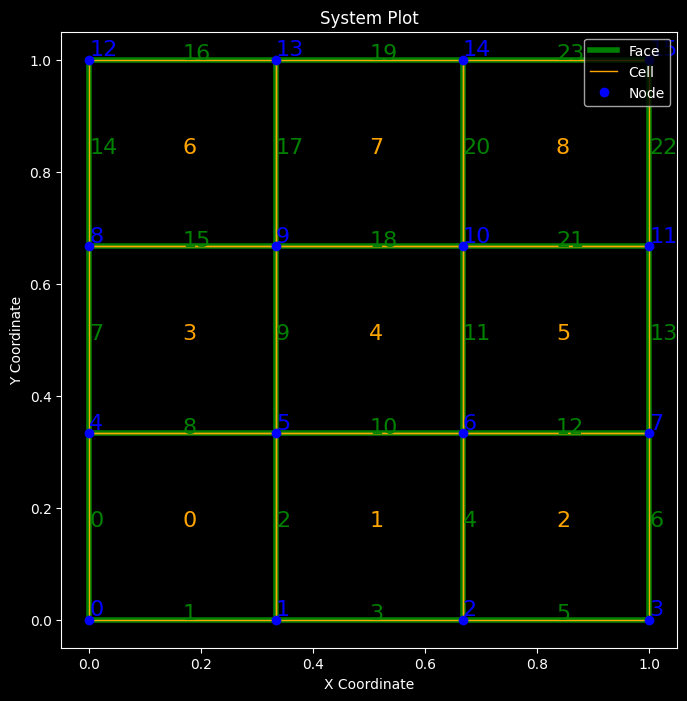

In [279]:
# Example Usage
system_size = (1, 1)  # Width and height of the system
num_cells = (3, 3)  # Number of cells in x and y directions
mesh = Mesh(*create_2d_rectangular_mesh(system_size, num_cells))
mesh.compute_cell_connectivity()

print(mesh)
mesh.print_detailed_info()
for cell in mesh.cells:
    print(cell)

mesh.plot()

#### Assigning flow variables to cells based on a field

ic| 'Cells:'
ic| cell: Cell(id=0, nodes=[0, 1, 5, 4], faces=[0, 1, 2, 8], neighbor_cells=[1, 3], flow_variables={'T': 282.23015028343025, 'U': None, 'P': None})
ic| cell: Cell(id=1, nodes=[1, 2, 6, 5], faces=[2, 3, 4, 10], neighbor_cells=[0, 2, 4], flow_variables={'T': 305.6517258108071, 'U': None, 'P': None})
ic| cell: Cell(id=2, nodes=[2, 3, 7, 6], faces=[4, 5, 6, 12], neighbor_cells=[1, 5], flow_variables={'T': 306.96676773132987, 'U': None, 'P': None})
ic| cell: Cell(id=3, nodes=[4, 5, 9, 8], faces=[7, 8, 9, 15], neighbor_cells=[0, 4, 6], flow_variables={'T': 290.915575482893, 'U': None, 'P': None})
ic| cell: Cell(id=4, nodes=[5, 6, 10, 9], faces=[9, 10, 11, 18], neighbor_cells=[1, 3, 5, 7], flow_variables={'T': 302.78476899193015, 'U': None, 'P': None})
ic| cell: Cell(id=5, nodes=[6, 7, 11, 10], faces=[11, 12, 13, 21], neighbor_cells=[2, 4, 8], flow_variables={'T': 295.0051075913935, 'U': None, 'P': None})
ic| cell: Cell(id=6, nodes=[8, 9, 13, 12], faces=[14, 15, 17, 16], neighbor

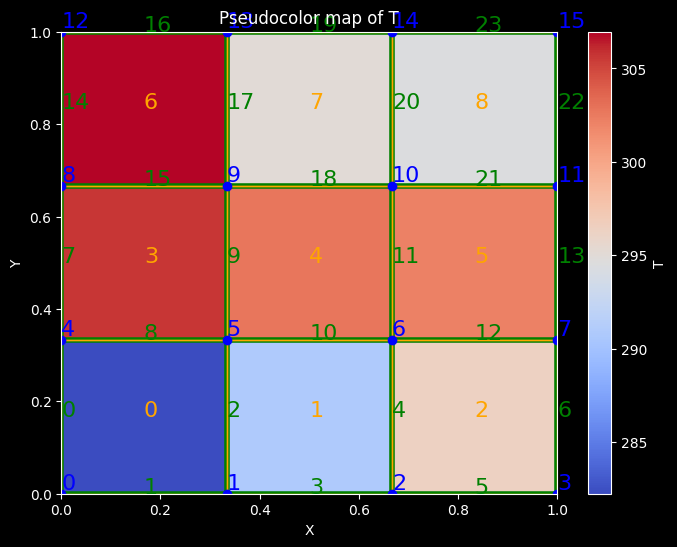

In [312]:
temp_field = np.ones(num_cells) * 290 + np.random.randn(*num_cells) * 10
assign_field_to_cells(mesh, temp_field.flatten(), "T")

# pressure_field = np.ones(num_cells) * 101
# assign_field_to_cells(mesh, pressure_field.flatten(), "P")

# velocity_field = np.ones((*num_cells,2)) * 0
# velocity_field = velocity_field.reshape(-1, 2)
# assign_field_to_cells(mesh, velocity_field, "U")

mesh.print_detailed_info("C")
plot_scalar_field(mesh, "T", num_cells, system_size, plot_mesh=True)

#### Calculating cell volumes

In [189]:
cell_volumes = []
for cell in mesh.cells:
    cell_nodes = [mesh.get_node(node_id) for node_id in cell.nodes]
    cell_volume = compute_cell_volume(mesh, cell)
    cell_volumes.append(cell_volume)
print(cell_volumes)


ic| cell_volumes: [0.25, 0.25, 0.25, 0.25]


[0.25, 0.25, 0.25, 0.25]

#### Calculating gradient of a field in the system

# Numerical solutions to different problems

## 1D Transient Heat Conduction

In [122]:
# Initialize parameters of the question
k = 50 # Thermal conductivity, W/K
L = 0.1 # m
A = 75e-6 # m^2
cp = 700 # Specific heat capacity, J/(kg * K)
rho = 200 # kg/m^3
# C = cp*rho # J/K, volume specific
alpha = k/(rho*cp) # thermal diffusivity, m^2/s
print(alpha)

# Drichlet boundary conditions
T_L = 390 # K, x=0
T_R = 290 # K, x=L


ic| alpha: 0.00035714285714285714


In [123]:
# discretize the space
n_elem = 10
n_nodes = n_elem + 1
l_elem = L/n_elem
dx = l_elem
elem_x = np.linspace(l_elem/2, L-l_elem/2, n_elem)
nodes_x = np.linspace(0, L, n_nodes)
print("Positions of nodes", nodes_x)

n_dof = n_elem # degree of freedom of the system

CON = [] # connectivity
for i in range(n_elem):
    CON.append([i, i+1])
print("Connectivty", CON)

class Element:
    def __init__(self, nodes, x, k, cp, rho, l):
        self.nodes = nodes
        self.x = x
        self.k = k
        self.cp = cp
        self.rho = rho
        self.l = l

    def __repr__(self):
        return f"Element(nodes={self.nodes})"

# create elements
elements = []
for i in range(n_elem):
    x = l_elem*(i+0.5)
    elements.append(Element(CON[i], elem_x[i], k, cp, rho, l_elem))

print("Elements", elements)

ic| "Positions of nodes": 'Positions of nodes'
    nodes_x: array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])
ic| "Connectivty": 'Connectivty'
    CON: [[0, 1],
          [1, 2],
          [2, 3],
          [3, 4],
          [4, 5],
          [5, 6],
          [6, 7],
          [7, 8],
          [8, 9],
          [9, 10]]
ic| "Elements": 'Elements'
    elements: [Element(nodes=[0, 1]),
               Element(nodes=[1, 2]),
               Element(nodes=[2, 3]),
               Element(nodes=[3, 4]),
               Element(nodes=[4, 5]),
               Element(nodes=[5, 6]),
               Element(nodes=[6, 7]),
               Element(nodes=[7, 8]),
               Element(nodes=[8, 9]),
               Element(nodes=[9, 10])]


('Elements',
 [Element(nodes=[0, 1]),
  Element(nodes=[1, 2]),
  Element(nodes=[2, 3]),
  Element(nodes=[3, 4]),
  Element(nodes=[4, 5]),
  Element(nodes=[5, 6]),
  Element(nodes=[6, 7]),
  Element(nodes=[7, 8]),
  Element(nodes=[8, 9]),
  Element(nodes=[9, 10])])

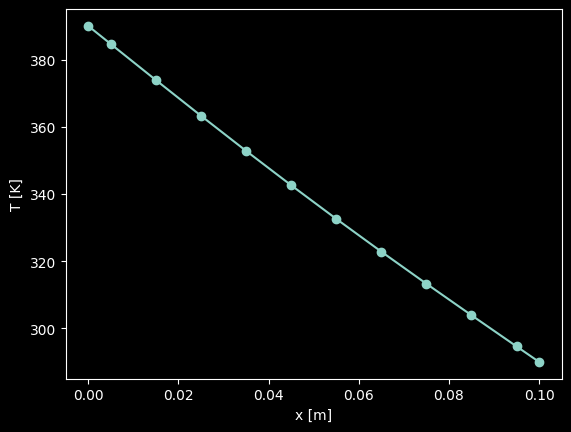

In [124]:
# discretize the time
t_final = 10
dt = 0.1
t = np.arange(0, t_final, dt)

# creating temperature values
T_0 = 273 # K, initial temperature
T = np.ones(n_dof) * T_0 # for two BC
dTdt = np.zeros(n_dof)

T_log = np.zeros((len(t), n_dof))
T_log[0] = T

plt.figure(1)

for j in range(len(t)):
    for i in range(n_dof):
        element = elements[i]
        alpha = element.k/(element.rho*element.cp)

        if i == 0: # left BC
            dTdt[i] = alpha*(
                -(T[i]-T_L)/(0.5*element.l**2)
                +(T[i+1]-T[i])/element.l**2
                )
        elif i == n_dof-1: # right bC
            dTdt[i] = alpha*(
                (T[i-1]-T[i])/element.l**2
                +(T_R-T[i])/(0.5*element.l**2)
                )
        else:
            dTdt[i] = alpha*(T[i+1]-2*T[i]+T[i-1])/element.l**2
    T = T + dTdt*dt
    T_log[j] = T

    plt.clf()
    plt.plot([0, *elem_x, L], [T_L, *T, T_R], marker="o")
    plt.xlabel("x [m]")
    plt.ylabel("T [K]")
    plt.show()
    display.clear_output(wait=True)


## 2D Steady Heat Conduction (explicit)

In [125]:
# properties
L = 1 # m
k = 50 # Thermal conductivity, W/K

# domain discretization
n_elem = 20 # in one direction
dx = dy = L/(n_elem+2)
# elem_x = np.linspace(dx/2, L-dx/2, n_elem) # to use this type of mesh, code should chane
# elem_y = np.linspace(dy/2, L-dy/2, n_elem)
elem_x = np.linspace(0, L, n_elem+2)
elem_y = np.linspace(0, L, n_elem+2)

elem_coords = np.array([(x, y) for x in elem_x for y in elem_y])
elem_coords[:5,:]

array([[0.        , 0.        ],
       [0.        , 0.04761905],
       [0.        , 0.0952381 ],
       [0.        , 0.14285714],
       [0.        , 0.19047619]])

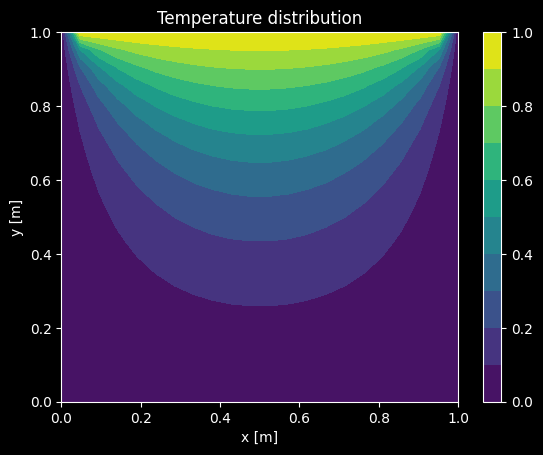

In [126]:
# temperature values
T = np.zeros((n_elem+2, n_elem+2))
# Drichlet BCs
T[0,:] = 1  # Top
T[-1,:] = 0 # Bottom
T[:,0] = 0  # Left
T[:,-1] = 0 # Right

T_new = T.copy()

tol = 1e-8
numerical_error = 2*tol
while numerical_error > tol:
    for i in range(1,n_elem+1):
        for j in range(1,n_elem+1):
            a_e = k/dx
            a_w = k/dx
            a_s = k/dy
            a_n = k/dy
            a_p = a_e + a_w + a_s + a_n
            T_new[i,j] = (a_e*T[i,j+1] + a_w*T[i,j-1] + a_n*T[i-1,j] + a_s*T[i+1,j])/a_p

    numerical_error = np.max(np.abs(T_new-T))

    T = T_new.copy()


# plot 2d map of temperaturs
X, Y = np.meshgrid(elem_x, L-elem_y)
plt.contourf(X, Y, T, 10)
# plt.pcolormesh(X, Y, T)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.colorbar()
plt.title(f"Temperature distribution")
plt.show()


## 2D Transient Heat Conduction (explicit)

In [127]:
# properties
L = 0.2 # m
k = 250 # Thermal conductivity, W/K
cp = 900 # Specific heat capacity, J/(kg * K)
rho = 2700 # kg/m^3
alpha = k/(rho*cp) # thermal diffusivity, m^2/s

n_elem = 10 # in one direction
dx = dy = L/(n_elem+2)
# dz = 1
dV = dx*dy
Ae = Aw = dy
An = As = dx

elem_x = np.linspace(0, L, n_elem+2)
elem_y = np.linspace(0, L, n_elem+2)
X, Y = np.meshgrid(elem_x, L-elem_y)


elem_coords = np.array([(x, y) for x in elem_x for y in elem_y])
elem_coords[:5,:]

array([[0.        , 0.        ],
       [0.        , 0.01818182],
       [0.        , 0.03636364],
       [0.        , 0.05454545],
       [0.        , 0.07272727]])

In [128]:
# temperature values
T = np.zeros((n_elem+2, n_elem+2))
# Drichlet BCs
T[-1,:] = 0 # Bottom
T[:,0] = 0  # Left
T[:,-1] = 200 # Right
T[0,:] = 300  # Top

t_final = 30
dt = 0.1
t = np.arange(0, t_final, dt)

plt.figure(1)
for k in range(len(t)):
    for i in range(1,n_elem+1):
        for j in range(1,n_elem+1):
            T_E = T[i,j-1]
            T_W = T[i,j+1]
            T_N = T[i-1,j]
            T_S = T[i+1,j]
            T_P = T[i,j]

            X_right = alpha*dt*Ae/dV * (T_E-T_P)/dx
            X_left = alpha*dt*Aw/dV * (T_W-T_P)/dx
            Y_up = alpha*dt*An/dV * (T_N-T_P)/dy
            Y_down = alpha*dt*As/dV * (T_S-T_P)/dy

            T[i,j] = T[i,j] + X_right + X_left + Y_up + Y_down

    # plt.pcolormesh(X, Y, T)
    plt.contourf(X, Y, T, 10)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.colorbar()
    plt.title(f"Temperature distribution")
    plt.show()
    display.clear_output(wait=True)


KeyboardInterrupt: 

## Lid-Driven Cavity

In [ ]:
# utils
def central_difference_x(f):
    """Calculates the central difference approximation of the x-derivative of a 2D field."""
    dfdx = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dx)
    # Set boundary values to zero
    dfdx[:, 0] = 0
    dfdx[:, -1] = 0
    dfdx[0, :] = 0
    dfdx[-1, :] = 0
    return dfdx

def central_difference_y(f):
    """Calculates the central difference approximation of the y-derivative of a 2D field."""
    dfdy = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dy)

    dfdy[:, 0] = 0
    dfdy[:, -1] = 0
    dfdy[0, :] = 0
    dfdy[-1, :] = 0
    return dfdy

def laplace(f):
    """Calculates the Laplacian of a 2D field using central differences."""
    d2fdx2 = (np.roll(f, -1, axis=1) - 2 * f + np.roll(f, 1, axis=1)) / (dx**2)
    d2fdy2 = (np.roll(f, -1, axis=0) - 2 * f + np.roll(f, 1, axis=0)) / (dy**2)
    laplacian_f = d2fdx2 + d2fdy2

    laplacian_f[:, 0] = 0
    laplacian_f[:, -1] = 0
    laplacian_f[0, :] = 0
    laplacian_f[-1, :] = 0

    return laplacian_f


In [ ]:
# properties and constants
nu = 0.1 # kinematic viscosity
rho = 1 # density
L = 1 # meter
n_elem = 50 # in one direction

HORIZONTAL_VELOCITY_TOP = 1
poisson_iterations = 50

dt = 0.001 # seconds
t_final = 1
t = np.arange(0, t_final, dt)

# discrete space
dx = dy = L/(n_elem+2)
l_elem = L/(n_elem+2)
x = np.linspace(0, L, n_elem+2) # extra elements are for boundaries
y = np.linspace(0, L, n_elem+2)
X,Y = np.meshgrid(x, y)

# stability check
max_dt = 0.5*dx*dy/nu
print(dt, max_dt)
if dt < max_dt:
    print("Time step is stable")
else:
    print("Time step is not stable")

In [ ]:
# fields
u_prev = np.zeros_like(X)
v_prev = np.zeros_like(X)
p_prev = np.zeros_like(X)

plt.figure(1)
for iteration in range(len(t)):
    du_dx = central_difference_x(u_prev)
    du_dy = central_difference_y(u_prev)
    dv_dx = central_difference_x(v_prev)
    dv_dy = central_difference_y(v_prev)
    laplace_u = laplace(u_prev)
    laplace_v = laplace(v_prev)

    # momentum equation without the pressure gradient
    u_tentative = u_prev + dt * (-(u_prev*du_dx + v_prev*du_dy) + nu * laplace_u)
    v_tentative = v_prev + dt * (-(u_prev*dv_dx + v_prev*dv_dy) + nu * laplace_v)

    # velocity drichlet boundary condition
    u_tentative[0, :] = 0.0
    u_tentative[:, 0] = 0.0
    u_tentative[:, -1] = 0.0
    u_tentative[-1, :] = HORIZONTAL_VELOCITY_TOP
    v_tentative[0, :] = 0.0
    v_tentative[:, 0] = 0.0
    v_tentative[:, -1] = 0.0
    v_tentative[-1, :] = 0.0

    # pressure corrections by solving the pressure-poisson equation
    du_dx = central_difference_x(u_tentative)
    dv_dy = central_difference_y(v_tentative)

    rhs = rho/dt * (du_dx + dv_dy)
    for _ in range(poisson_iterations):
        p_next = np.zeros_like(p_prev)
        p_next[1:-1, 1:-1] = 1/4 * (
            p_prev[1:-1, :-2] +
            p_prev[:-2, 1:-1] +
            p_prev[2:, 1:-1] +
            p_prev[1:-1, 2:] -
            dx*dy * rhs[1:-1, 1:-1]
        )
        # pressure neuman boundary conditions, except top (drichlet)
        p_next[:, -1] = p_next[:, -2]
        p_next[0,  :] = p_next[1,  :]
        p_next[:,  0] = p_next[:,  1]
        p_next[-1, :] = 0.0

        p_prev = p_next

    dp_dx = central_difference_x(p_next)
    dp_dy = central_difference_y(p_next)

    # velocity correction
    u_next = (
        u_tentative - dt * (dp_dx / rho)
    )
    v_next = (
        v_tentative - dt * (dp_dy / rho)
    )

    # velocity drichlet boundary condition
    u_next[0, :] = 0.0
    u_next[:, 0] = 0.0
    u_next[:, -1] = 0.0
    u_next[-1, :] = HORIZONTAL_VELOCITY_TOP
    v_next[0, :] = 0.0
    v_next[:, 0] = 0.0
    v_next[:, -1] = 0.0
    v_next[-1, :] = 0.0

    u_prev = u_next
    v_prev = v_next
    p_prev = p_next



plt.pcolormesh(X, Y, p_next)
plt.contourf(X, Y, p_next, 10)
plt.quiver(X, Y, u_next, v_next, color="black")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.colorbar()
plt.title(f"Lid Driven Cavity")
plt.show()
# display.clear_output(wait=True)

